## SENTIMENT ANALYSIS BASED ON TWITTER TWEETS OF COVID-19

### Importing Necessary Libraries

In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re

import nltk
from nltk import stem  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords

from tqdm import tqdm

In [3]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Loading The Dataset

In [4]:
df = pd.read_csv(r"C:\Users\USER\zzzz\covid19_tweets.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


In [5]:
len(df)

179108

### Pre-Processing The Data

In [6]:
!pip install neattext
import neattext as nfx

In [7]:
df=df.fillna(0)
df.replace(" ", float("NaN"), inplace=True)
df= df.dropna()

In [8]:
df['text'].apply(nfx.extract_hashtags)

df['clean_tweet'] = df['text'].apply(lambda x: nfx.remove_userhandles(x))

# Cleaning Text: Multiple WhiteSpaces
df['clean_tweet'] = df['clean_tweet'].apply(nfx.remove_multiple_spaces)

# Cleaning Text : Remove urls
df['clean_tweet'] = df['clean_tweet'].apply(nfx.remove_urls)

# Cleaning Text: Punctuations
df['clean_tweet'] = df['clean_tweet'].apply(nfx.remove_puncts)

df[["text","clean_tweet"]]

,text,clean_tweet
0,If I smelled the scent of hand sanitizers toda...,If I smelled the scent of hand sanitizers toda...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,Hey and wouldnt it have made more sense to ha...
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,Trump never once claimed #COVID19 was a hoax ...
3,@brookbanktv The one gift #COVID19 has give me...,The one gift #COVID19 has give me is an appre...
4,25 July : Media Bulletin on Novel #CoronaVirus...,25 July : Media Bulletin on Novel #CoronaVirus...
...,...,...
179103,Thanks @IamOhmai for nominating me for the @WH...,Thanks for nominating me for the #WearAMask ch...
179104,2020! The year of insanity! Lol! #COVID19 http...,2020 The year of insanity Lol #COVID19
179105,@CTVNews A powerful painting by Juan Lucena. I...,A powerful painting by Juan Lucena Its a trib...
179106,"More than 1,200 students test positive for #CO...",More than 1200 students test positive for #COV...


In [9]:
df.isnull().sum()

user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
is_retweet          0
clean_tweet         0
dtype: int64

In [10]:
len(df[df.duplicated()]) , len(df)

(0, 179075)

In [11]:
df=df[['user_location','date','text','clean_tweet']]

In [12]:
df.head()

,user_location,date,text,clean_tweet
0,astroworld,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,If I smelled the scent of hand sanitizers toda...
1,"New York, NY",2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,Hey and wouldnt it have made more sense to ha...
2,"Pewee Valley, KY",2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,Trump never once claimed #COVID19 was a hoax ...
3,Stuck in the Middle,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,The one gift #COVID19 has give me is an appre...
4,Jammu and Kashmir,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,25 July : Media Bulletin on Novel #CoronaVirus...


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179075 entries, 0 to 179107
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_location  179075 non-null  object
 1   date           179075 non-null  object
 2   text           179075 non-null  object
 3   clean_tweet    179075 non-null  object
dtypes: object(4)
memory usage: 6.8+ MB


In [14]:
df.describe()

,user_location,date,text,clean_tweet
count,179075,179075,179075,179075
unique,26920,136585,178650,165909
top,0,2020-08-06 16:00:00,"The incompetence of this administration, and t...",
freq,36771,26,13,558


In [15]:
df.duplicated().sum()

0

In [16]:
df['user_location'].unique()

array(['astroworld', 'New York, NY', 'Pewee Valley, KY', ...,
       'Newton, NJ', 'T.O.', 'Aliwal North, South Africa'], dtype=object)

In [17]:
df.dtypes

user_location    object
date             object
text             object
clean_tweet      object
dtype: object

## Sentiment Analysis (Using Textblob)...........................................................ALL TWEETS

In [18]:
from textblob import TextBlob

In [19]:
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity
    
    if 0 < sentiment_polarity <= 0.3:
        sentiment_label = 'Weakly Positive'
    elif -0.6 < sentiment_polarity <= -0.3:
        sentiment_label = 'Negative'
    elif 0.3 < sentiment_polarity <= 0.6:
        sentiment_label = 'Positive'
    elif 0.6 < sentiment_polarity <= 1:
        sentiment_label = 'Strongly Positive'
    elif -0.3 < sentiment_polarity <= 0:
        sentiment_label = 'Weakly Negative'
    elif -1 < sentiment_polarity <= -0.6:
        sentiment_label = 'Strongly Negative'
    else:
        sentiment_label= 'Neutral'
       
    result = {'sentiment':sentiment_label, 'Polarity':sentiment_polarity, 'Subjectivity':sentiment_subjectivity}
    return result

In [20]:
df['sentiment_results'] = df['clean_tweet'].apply(get_sentiment)
df = df.join(pd.json_normalize(df['sentiment_results']))

## RESULT OF SENTIMENT ANALYSIS

In [21]:
sentiment_count = df['sentiment'].value_counts().reset_index()
sentiment_count.columns = ['Sentiment','Count']
sentiment_count

,Sentiment,Count
0,Weakly Negative,95586
1,Weakly Positive,47450
2,Positive,22420
3,Negative,6558
4,Strongly Positive,4683
5,Strongly Negative,1750
6,Neutral,595


Text(0, 0.5, 'Count')

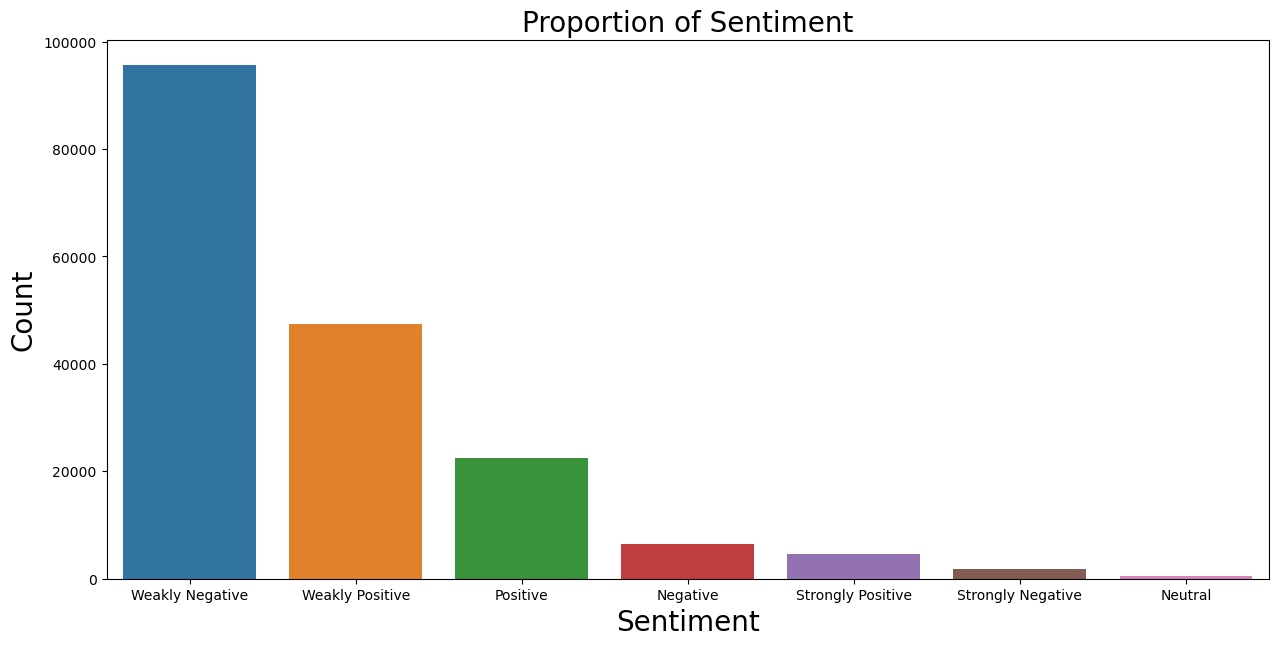

In [22]:
plt.figure(figsize=(15,7))
ax = sns.barplot(x="Sentiment", y='Count', data=sentiment_count)
ax.set_title("Proportion of Sentiment", fontsize=20)
ax.set_xlabel("Sentiment", fontsize=20)
ax.set_ylabel('Count', fontsize=20)

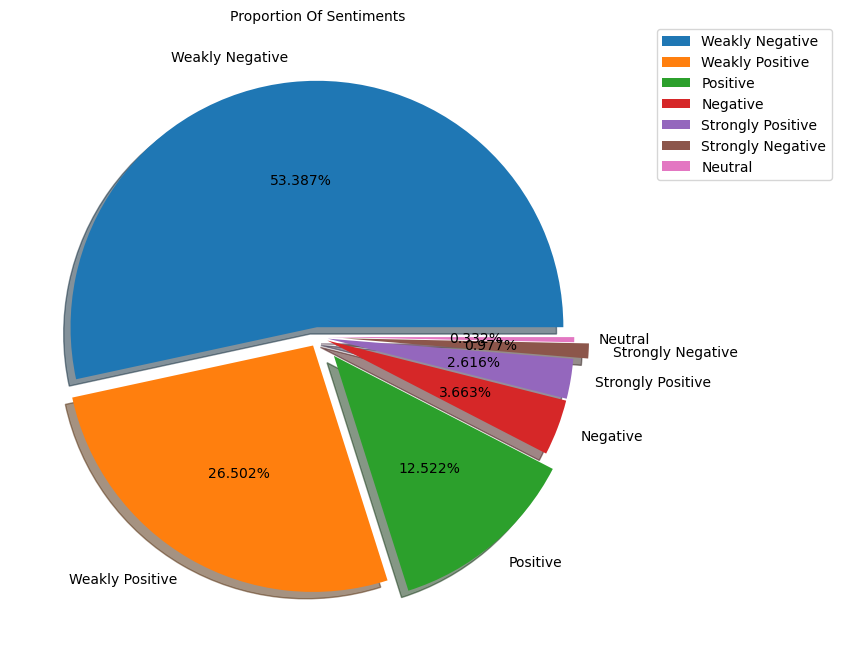

In [23]:
# Plotting the piechart for Sentiments distribution
sentiment_count = df['sentiment'].value_counts().to_list()
labels=['Weakly Negative','Weakly Positive','Positive','Negative','Strongly Positive','Strongly Negative','Neutral']
plt.figure(figsize=(8,8))
plt.pie(x=sentiment_count,explode=[0.04,0.04,0.1,0.04,0.04,0.1,0.04],shadow= True,labels=labels,autopct="%1.3f%%",radius=1)
plt.title("Proportion Of Sentiments", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## Extracting tweets based on India

In [24]:
len(df)

179075

In [25]:
#Checking df location has following state and capital names
# user_location= Bangalore
# user_location= India not included
# user_location= Bangalore,India will NOT be included in this df

place = ['भारत','Andhra Pradesh','Amravati','Arunachal Pradesh','Itanagar','Assam','Dispur','Bihar','Patna',
       'Chhattisgarh','Atal Nagar','Goa','Panaji','Gujarat','Gandhinagar','Haryana','Chandigarh',
       'Himachal Pradesh','Shimla','Jharkhand','Ranchi','Karnataka','Bengaluru','Bangalore',
       'Kerala','Thiruvananthapuram','Madhya Pradesh','MP','Bhopal','Maharashtra','Bombay',
       'Mumbai','Manipur','Imphal' ,'Meghalaya','Shillong','Mizoram','Aizawl','Nagaland',
       'Kohima','Odisha','Orissa','Bhubaneswar','Punjab','Chandigarh','Rajasthan','Jaipur',
       'Sikkim','Gangtok','Tamil Nadu','Chennai','Telangana','Hyderabad','Tripura','Agartala',
       'Uttar Pradesh','Lucknow','Uttarakhand','Dehradun','West Bengal','Kolkata']

df_pl = df[df['user_location'].isin(place)]

In [26]:
# String having substring "INDIA | india| India|Bharat|bharat" is included
#user_location= Bangalore,India will be included in this df
#user_location= Bangalore will NOT be included
#user_location= India not included

df_In = df.loc[df['user_location'].str.contains("INDIA | india| India|Bharat|bharat", na=False)]

In [27]:
Location = [df_pl, df_In]

dfi = pd.concat(Location)

In [28]:
len(df_pl) , len(df_In), len(dfi)

(2193, 9946, 12139)

## Sentiment Counts ........................................................... TWEETS OF INDIAN AUDIENCE

In [29]:
sentiment_count1 = dfi['sentiment'].value_counts().reset_index()
sentiment_count1.columns = ['Sentiment','Count']
sentiment_count1

,Sentiment,Count
0,Weakly Negative,6485
1,Weakly Positive,3268
2,Positive,1456
3,Negative,440
4,Strongly Positive,317
5,Strongly Negative,115
6,Neutral,58


Text(0, 0.5, 'Count')

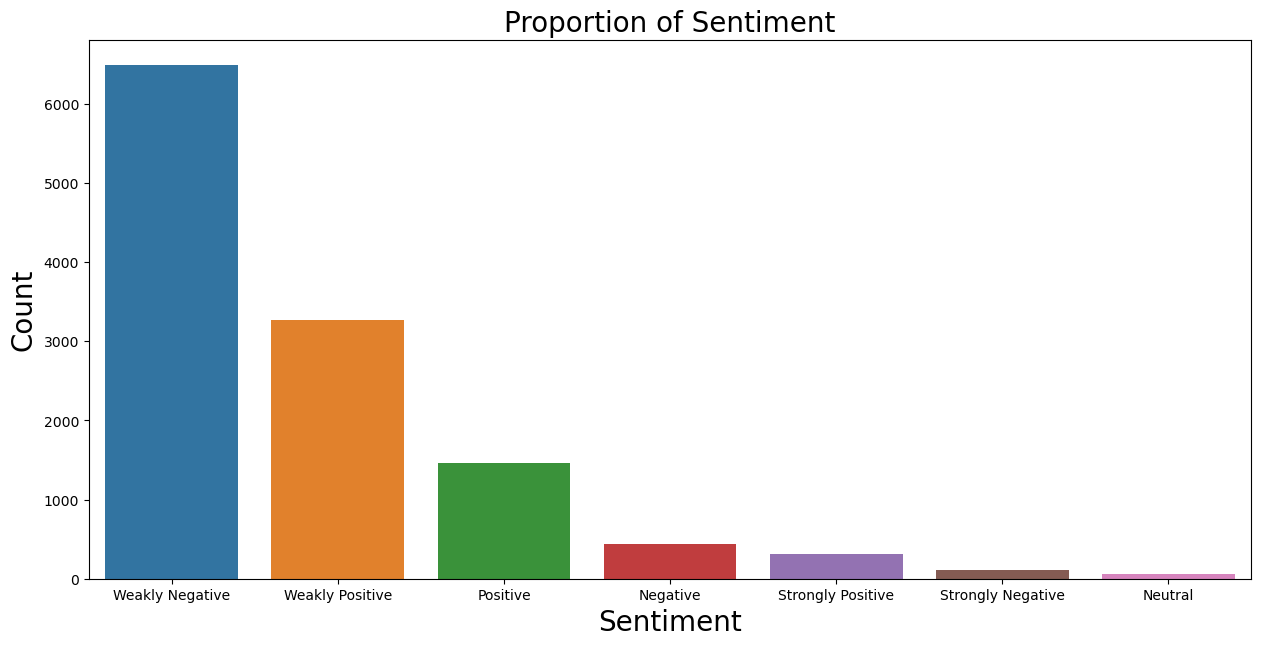

In [30]:
plt.figure(figsize=(15,7))
ax = sns.barplot(x="Sentiment", y='Count', data=sentiment_count1)
ax.set_title("Proportion of Sentiment", fontsize=20)
ax.set_xlabel("Sentiment", fontsize=20)
ax.set_ylabel("Count", fontsize=20)

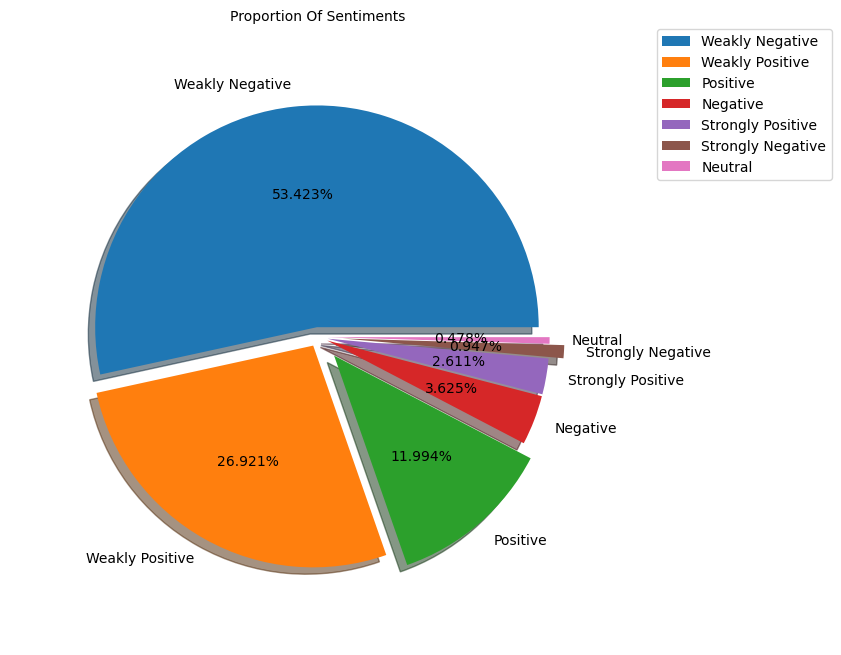

In [31]:
# Plotting the piechart for Sentiments distribution
sentiment_count1 = dfi['sentiment'].value_counts().to_list()
labels=['Weakly Negative','Weakly Positive','Positive','Negative','Strongly Positive','Strongly Negative','Neutral']
plt.figure(figsize=(8,8))
plt.pie(x=sentiment_count1,explode=[0.04,0.04,0.1,0.04,0.04,0.1,0.04],shadow= True,labels=labels,autopct="%1.3f%%",radius=0.9)
plt.title("Proportion Of Sentiments", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## Tokenizing Tweets

In [32]:
# function to remove puntuation
def remove_puntuation(text):
    text = [word for word in text if word.isalpha()] #  remove all puntuation and numbers
    return text 

# function to remove stop word from text
def remove_stopwords(text):
    stop_words = list(stopwords.words('english')) # store nltk stopwords
    text = [word for word in text if not word in stop_words] 
    return text 

# function to perform lemmatization
def lemmatization (text):
    lemmatizer = stem.WordNetLemmatizer() 
    text = [lemmatizer.lemmatize(token) for token in text]
    return text 


# function to perform text preprocessing (lemmatization and no stemming)
def clean_corpus(text):
    
    text = text.lower()                # lower case  
    token = word_tokenize(text)         # tokenise
  
    token = remove_stopwords(token)    # remove stopwords
    token = remove_puntuation(token)   # remove puntuation 
    token = lemmatization(token)       # lemmatize

    all_tokens = " ".join(token)       # join all tokens

    return all_tokens

In [33]:
# preprocess training data
dfi['processed_text'] = dfi['clean_tweet'].apply(lambda x: clean_corpus(x))

In [34]:
dfi[['clean_tweet','processed_text']]

,clean_tweet,processed_text
322,#AndhraPradesh reports 7813 new #COVID19 cases...,andhrapradesh report new case saturday tally g...
399,2021 Australian Open: Smaller crowds player bi...,australian open smaller crowd player biosecuri...
539,Actor and his father MrGKReddy tested positive...,actor father mrgkreddy tested positive day bac...
596,#MadhyaPradeshCM #ShivrajSinghChouhan tests po...,madhyapradeshcm shivrajsinghchouhan test posit...
999,Treat every single decision you take regarding...,treat every single decision take regarding go ...
...,...,...
178941,Maha records new peak of 16K plus cases deaths...,maha record new peak plus case death cross rou...
178942,You cowards remember this first all indians ...,coward remember first indian knew people power...
178945,Online education remains a dream for the under...,online education remains dream underprivileged...
179034,#FDA extended emergency use authorization of #...,fda extended emergency use authorization veklu...


# Summarizing Tweets

dfsum= dfi[['clean_tweet']]
dfsum.info()

!pip install tensorflow --upgrade
!pip install tensorflow-gpu --upgrade

pip install keras --upgrade

pip install tensorflow==2.9

from transformers import T5Tokenizer, T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

def summ(text):
    TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    
    Preprocessed_text = "summarize: "+ text
    tokens_input = tokenizer.encode(Preprocessed_text,return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(tokens_input, min_length=60,max_length=180, length_penalty=4.0)
    summary = tokenizer.decode(summary_ids[0])
    result = summary
    return result

dfsum['summary'] = dfsum['clean_tweet'].apply(summ)
dfsum = dfsum.join(pd.json_normalize(dfsum['summary']))

# MOOD analysis

def summ(text):
    result= (summarize(text))
    return result

dfi['clean_tweet'].apply(str)

dfsum[:5]

dfsum['summary'] = dfsum['clean_tweet'].apply(summ)
dfsum = dfsum.join(pd.json_normalize(dfsum['summary']))